In [1]:
%matplotlib inline

import os

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.patches import Circle
from matplotlib.patches import Ellipse

from skimage.filters import threshold_otsu
from skimage.filters import sobel

import lmfit
from lmfit import Model

from tifffile import TiffFile

In [ ]:
def plot(image, params=None):
            
    fig, ax = plt.subplots()
    im_ax = ax.imshow(image, cmap=plt.cm.BrBG, interpolation='nearest', origin='lower')

    if params:
        ax.scatter(params['x0'], params['y0'], s=100, c="red", marker="x")

        circle = Circle((params['x0'], params['y0']), params['sigma'], facecolor='none',
                edgecolor="red", linewidth=1, alpha=0.8)
        ax.add_patch(circle)
        
    plt.colorbar(im_ax)

# 2D Gaussian model
def func(xy, x0, y0, sigma, H):

    x, y = xy
    
    A = 1 / (2 * sigma**2)
    I = H * np.exp(-A * ( (x - x0)**2 + (y - y0)**2))
    
    return I

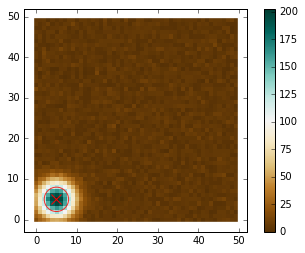

In [95]:
# Generate model

true_params = {'x0': 5, 'y0': 5, 'sigma': 3, 'H': 200}

x = np.arange(0, 50, 1)
y = np.arange(0, 50, 1)
xy = np.meshgrid(x, y)

model = Model(func)
image = model.eval(xy=xy, **true_params)
image += np.random.poisson(5, image.shape)
plot(image, true_params)

H guess : 196.99106017819247
[[Model]]
    Model(func)
[[Fit Statistics]]
    # function evals   = 85
    # data points      = 2500
    # variables        = 4
    chi-square         = 70446.751
    reduced chi-square = 28.224
    Akaike info crit   = 8358.419
    Bayesian info crit = 8381.715
[[Variables]]
    x0:      5.00456894 +/- 0.021736 (0.43%) (init= 25)
    y0:      5.00448600 +/- 0.021736 (0.43%) (init= 25)
    sigma:   3.12933197 +/- 0.016463 (0.53%) (init= 25)
    H:       201.230519 +/- 1.395864 (0.69%) (init= 196.9911)
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, H)                  = -0.723 



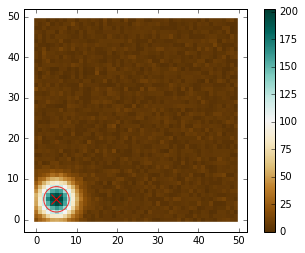

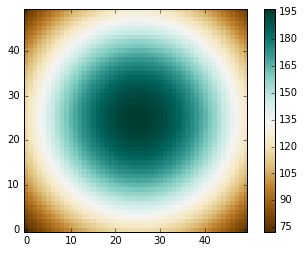

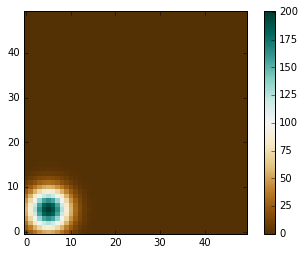

In [96]:
# Fit generated model

# Guess initials parameters
model.set_param_hint('x0', value=25, min=0, max=300)
model.set_param_hint('y0', value=25, min=0, max=300)
model.set_param_hint('sigma', value=25, min=0, max=100)

## Guessing height (H) value
background = image[image < threshold_otsu(image)].mean()
h_guess = image.max() - background
print("H guess : {}".format(h_guess))
model.set_param_hint('H', value=h_guess, min=background, max=image.max() * 10)

# Prepare fit
x = np.arange(0, image.shape[1], 1)
y = np.arange(0, image.shape[0], 1)
xy = np.meshgrid(x, y)

# Fit
result = model.fit(image, xy=xy, method='leastsq')

# Plot result
predicted_params = result.params
plot(image, predicted_params)

plot(result.init_fit)
plot(result.best_fit)

print(result.fit_report())
#lmfit.printfuncs.report_ci(result.conf_interval())

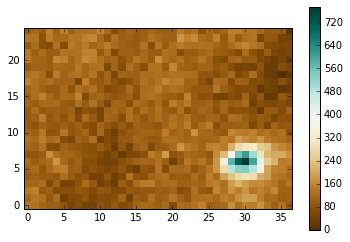

In [97]:
image = TiffFile("spot.tif").asarray()

# Rescaling image to get 0 for the lowest value
image -= image.min()

plot(image)

H guess : 667.1509433962265
[[Model]]
    Model(func)
[[Fit Statistics]]
    # function evals   = 71
    # data points      = 925
    # variables        = 4
    chi-square         = 3976847.970
    reduced chi-square = 4317.967
    Akaike info crit   = 7750.750
    Bayesian info crit = 7770.069
[[Variables]]
    x0:      31.8998257 +/- 5.686583 (17.83%) (init= 15)
    y0:      3.1123e-07 +/- 1.104623 (354924164.83%) (init= 15)
    sigma:   34.4336035 +/- 7.057235 (20.50%) (init= 25)
    H:       140.745775 +/- 6.674831 (4.74%) (init= 667.1509)
[[Correlations]] (unreported correlations are <  0.100)
    C(x0, sigma)                 =  0.924 
    C(y0, sigma)                 =  0.835 
    C(y0, H)                     =  0.775 
    C(x0, y0)                    =  0.771 
    C(x0, H)                     =  0.656 
    C(sigma, H)                  =  0.526 



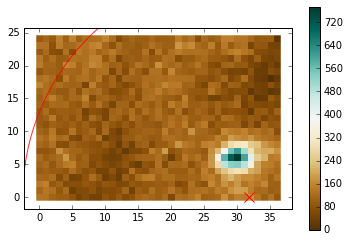

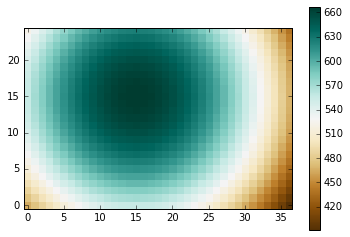

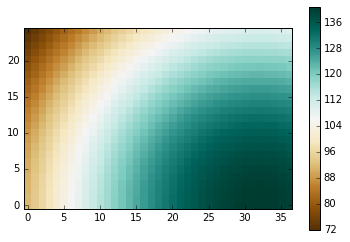

In [98]:
# Fit generated model

model = Model(func)

# Guess initials parameters
model.set_param_hint('x0', value=15, min=0, max=300)
model.set_param_hint('y0', value=15, min=0, max=300)
model.set_param_hint('sigma', value=25, min=0, max=300)

## Guessing height (H) value
background = image[image < threshold_otsu(image)].mean()
h_guess = image.max() - background
print("H guess : {}".format(h_guess))
model.set_param_hint('H', value=h_guess, min=background, max=image.max() * 10)
# Prepare fit
x = np.arange(0, image.shape[1], 1)
y = np.arange(0, image.shape[0], 1)
xy = np.meshgrid(x, y)

# Fit
result = model.fit(image, xy=xy, verbose=False)

# Plot result
predicted_params = result.params
plot(image, predicted_params)

plot(result.init_fit)
plot(result.best_fit)

print(result.fit_report())